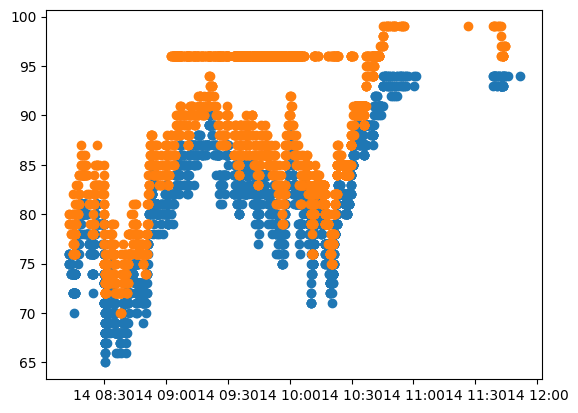

In [23]:
# Plot a market
import matplotlib.pyplot as plt 
data = db.read("INXZ-23SEP14-T4467.44")
ob = [i for i in data]
bbos = [(o.get_bbo(), o.ts) for o in ob]
bids = [(o.bid,ts) for o,ts in bbos if o is not None]
bids = [(o.price, ts) for o, ts in bids if o is not None]
asks =  [(o.ask,ts) for o,ts in bbos if o is not None]
asks = [(o.price,ts) for o,ts in asks if o is not None]
plt.scatter([ts for _, ts in bids], [p for p, _ in bids])
plt.scatter([ts for _, ts in asks], [p for p, _ in asks])
plt.show()

In [2]:
# Create file (only need to run once)
from strategy.utils import get_spy_ob_bbo_merged_df
from data.coledb.coledb import ColeDBInterface
from helpers.types.markets import MarketTicker
db = ColeDBInterface()
df = get_spy_ob_bbo_merged_df(db, "/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/databento/xnas-itch/spy/xnas-itch-20230914.mbo.csv", MarketTicker("INXZ-23SEP14-T4467.44"))
df.to_csv("/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/bbo_INXZ_and_SPY_09142023.csv")

1. first clean data, remove rows with nan spy. Then, divide spy price by 10000000 (to convert to cents). Take all times between 9:30 AM an d 4 PM
2. lag ES data by certain amount of time (maybe 0 seconds, 500 millis, 1 second, 2 seconds, 3 seconds, 4 seconds, 5 seconds, 10 seconds)
3. for each lagged df, tune hyper params 
4. params to tune are: m,b, and shift_up

In [2]:
####### START HERE ############
# Load data (instead of creating)
import pandas as pd

# LOAD DATA
df = pd.read_csv("/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/bbo_INXZ_and_SPY_09142023.csv")

# First remove any rows with nan spy (cleaned_df)
cdf = df[df['spy_price'].notna()]
cdf['spy_price'] /= 10000000
cdf = cdf[(cdf.ts >= 1694698200) & (cdf.ts <= 1694721600)]
cdf = cdf[((cdf.yes_bid_price).notna()) & ((cdf.yes_ask_price).notna())]
# Next (skipped) lag the data
...


/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1130/3482526949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['spy_price'] /= 10000000


Ellipsis

In [185]:
import numpy as np
from scipy.optimize import basinhopping, minimize

# Finally, optimize
start_day_price = 44907
close_time_unix = 1694721600

def get_cdf_with_params(x):
    m = x[0]
    b = x[1]
    # shift_up = x[2]
    # Sigmoid is already between 0 and 1, no need to shift up for now 
    shift_up = 0
    """Minimization functions for the bids"""
    cdf['w'] = m * (close_time_unix - df.ts) + b
    cdf['sigmoid'] = (1 / (1 + np.exp(-(start_day_price - cdf.spy_price) * cdf.w))) + shift_up
    return cdf

def minimize_bids(x):
    cdf = get_cdf_with_params(x)
    # Adjust below for bids (yes_ask_price)
    return abs((100*cdf.sigmoid) - cdf.yes_bid_price).sum()
def callback(x, f, accepted):
    print(f"Iteration {callback.iteration}: x = {x}, f(x) = {f}, accepted = {accepted}")
    callback.iteration += 1
callback.iteration = 0
# Nelder-Mean method
result = minimize(
        minimize_bids,
        [0, 0],
        method="Nelder-Mead",
    )
# Basin-hopping
# result = basinhopping(
#         minimize_bids,
#         [0, 0],
#         stepsize=0.1,
#         callback=callback
#     )
result.x

array([ 3.91620951e-06, -5.84048383e-02])

##### TODO:

1. (done) Figure out good bounds for hyper params -- it's returning the same values everywhere (find out why). You might need to use diff optimizations
2. **TODO** figure out why it's inversely correlated
3. Run for asks as well 
4. Finally, try to lag the data some time 

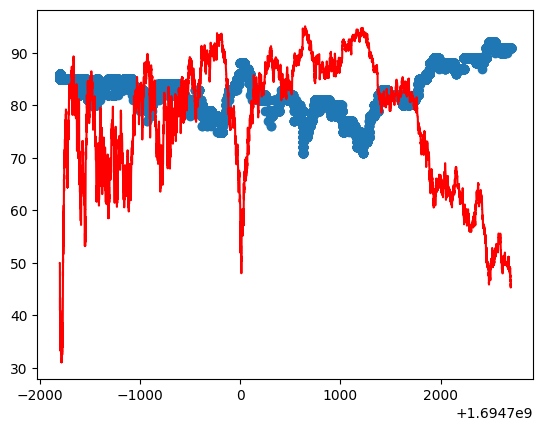

In [186]:
cdf_with_params = get_cdf_with_params(result.x)

plt.plot(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_bid_price)
plt.show()